In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Install required libraries
!pip install torch torchvision --quiet
!pip install easyocr --quiet
!pip install opencv-python-headless --quiet
!pip install ultralytics --quiet  # For YOLOv8

import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import easyocr
from ultralytics import YOLO


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 15.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import zipfile
import os
!pip install torch torchvision --quiet
!pip install easyocr --quiet
!pip install opencv-python-headless --quiet
!pip install ultralytics --quiet  # For YOLOv8

import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import easyocr
from ultralytics import YOLO

# Paths to the zip files
detection_zip_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test.zip'  # The zip file for detection images
recognition_zip_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesrecognition_train.zip'  # The zip file for recognition images

# Destination folders where the images will be extracted
detection_extract_path = '/content/extracted_detection_images'
recognition_extract_path = '/content/extracted_recognition_images'

# Function to extract zip files
def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

# Extract detection and recognition images
extract_zip(detection_zip_path, detection_extract_path)
extract_zip(recognition_zip_path, recognition_extract_path)


Extracted /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test.zip to /content/extracted_detection_images
Extracted /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesrecognition_train.zip to /content/extracted_recognition_images


In [ ]:
df.columns

Index(['img_id', 'ymin', 'xmin', 'ymax', 'xmax'], dtype='object')

In [ ]:
import os
import pandas as pd

# Paths
CSV_FILE_PATH = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesdetection_train.csv"  # Path to the CSV file
IMAGE_DIR = "/content/extracted_detection_images/license_plates_detection_train"  # Path to the folder containing images

# Load CSV file
try:
    df = pd.read_csv(CSV_FILE_PATH, delimiter=",")  # Assuming tab-delimited CSV
    print(f"Loaded {len(df)} annotations from {CSV_FILE_PATH}.")
except Exception as e:
    print(f"Error loading CSV: {e}")
    raise

# Extract unique image IDs from the CSV
csv_image_ids = set(df['img_id'].unique())
print(f"Unique image IDs in CSV: {len(csv_image_ids)}")

# Get all image filenames in the directory
image_filenames = set(os.listdir(IMAGE_DIR))
print(f"Total images in directory: {len(image_filenames)}")

# Cross-check
images_with_annotations = csv_image_ids & image_filenames
missing_annotations = image_filenames - csv_image_ids
orphan_annotations = csv_image_ids - image_filenames

# Results
print("\nSummary:")
print(f"Images with annotations: {len(images_with_annotations)}")
print(f"Images without annotations: {len(missing_annotations)}")
print(f"Annotations without images: {len(orphan_annotations)}")

# Save results for review
with open("missing_annotations.txt", "w") as f:
    f.writelines(f"{img}\n" for img in missing_annotations)

with open("orphan_annotations.txt", "w") as f:
    f.writelines(f"{img}\n" for img in orphan_annotations)

print("\nDetails saved to 'missing_annotations.txt' and 'orphan_annotations.txt'.")


Loaded 900 annotations from /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesdetection_train.csv.
Unique image IDs in CSV: 900
Total images in directory: 900

Summary:
Images with annotations: 900
Images without annotations: 0
Annotations without images: 0

Details saved to 'missing_annotations.txt' and 'orphan_annotations.txt'.


In [ ]:
import os
import pandas as pd
from PIL import Image

# Paths
csv_file_path = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesdetection_train.csv"
images_directory = "/content/extracted_detection_images/license_plates_detection_train"
output_directory = "/content/yolo_labels"

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Load the CSV file
data = pd.read_csv(csv_file_path)
data.columns = [col.strip() for col in data.columns]  # Clean column names

# Ensure the CSV has the correct structure
required_columns = {"img_id", "xmin", "ymin", "xmax", "ymax"}
if not required_columns.issubset(data.columns):
    raise ValueError(f"CSV file must contain the following columns: {required_columns}")

# Iterate through each image and process annotations
for img_id, group in data.groupby("img_id"):
    image_path = os.path.join(images_directory, img_id)
    if not os.path.exists(image_path):
        print(f"Warning: Image {img_id} not found in {images_directory}. Skipping.")
        continue

    # Open the image to get dimensions
    with Image.open(image_path) as img:
        img_width, img_height = img.size

    # Prepare YOLO format annotations
    yolo_annotations = []
    for _, row in group.iterrows():
        # Normalize coordinates
        x_center = ((row["xmin"] + row["xmax"]) / 2) / img_width
        y_center = ((row["ymin"] + row["ymax"]) / 2) / img_height
        width = (row["xmax"] - row["xmin"]) / img_width
        height = (row["ymax"] - row["ymin"]) / img_height

        # Append class ID (0 for single class) and normalized coordinates
        yolo_annotations.append(f"0 {x_center} {y_center} {width} {height}")

    # Save annotations to a text file in YOLO format
    output_file_path = os.path.join(output_directory, os.path.splitext(img_id)[0] + ".txt")
    with open(output_file_path, "w") as f:
        f.write("\n".join(yolo_annotations))

print(f"YOLO annotations saved to: {output_directory}")


YOLO annotations saved to: /content/yolo_labels


In [ ]:
import os
import shutil
import random

# Paths
images_directory = '/content/extracted_detection_images/license_plates_detection_train'  # Path to images
labels_directory = '/content/yolo_labels'  # Path to YOLO annotations
train_images_dir = '/content/train/images'  # Path for training images
train_labels_dir = '/content/train/labels'  # Path for training labels
val_images_dir = '/content/val/images'  # Path for validation images
val_labels_dir = '/content/val/labels'  # Path for validation labels

# Create train and val directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Get the list of image files
image_files = [f for f in os.listdir(images_directory) if f.endswith('.jpg')]  # Assuming images are in .jpg format

# Shuffle the list of image files
random.shuffle(image_files)

# Split into 80% train and 20% validation
split_ratio = 0.8
train_size = int(len(image_files) * split_ratio)
train_files = image_files[:train_size]
val_files = image_files[train_size:]

# Function to move files to the appropriate directories
def move_files(files, src_image_dir, src_label_dir, dest_image_dir, dest_label_dir):
    for file in files:
        # Move images
        shutil.move(os.path.join(src_image_dir, file), os.path.join(dest_image_dir, file))

        # Move corresponding label files
        label_file = os.path.splitext(file)[0] + '.txt'  # Assuming labels have the same name as images
        shutil.move(os.path.join(src_label_dir, label_file), os.path.join(dest_label_dir, label_file))

# Move training and validation files
move_files(train_files, images_directory, labels_directory, train_images_dir, train_labels_dir)
move_files(val_files, images_directory, labels_directory, val_images_dir, val_labels_dir)

print(f"Dataset split into {len(train_files)} training and {len(val_files)} validation samples.")


Dataset split into 720 training and 180 validation samples.


In [ ]:
import yaml

# Define paths for training and validation sets
train_images_path = '/content/train/images'
val_images_path = '/content/val/images'

# Number of classes
num_classes = 1
class_names = ['license_plate']

# Create the data.yaml content
data_yaml = {
    'train': train_images_path,
    'val': val_images_path,
    'nc': num_classes,
    'names': class_names
}

# Define the path for saving the data.yaml file
yaml_file_path = '/content/data.yaml'

# Write the YAML file
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(data_yaml, yaml_file)

print(f"data.yaml file has been created and saved to {yaml_file_path}")


data.yaml file has been created and saved to /content/data.yaml


In [ ]:
from ultralytics import YOLO

# Path to your custom data.yaml file
data_yaml_path = '/content/data.yaml'

# Load the YOLOv8 model (can be yolov8n, yolov8s, yolov8m, yolov8l, etc. depending on your requirements)
model = YOLO('yolov8n.yaml')  # You can try 'yolov8s.yaml' or 'yolov8m.yaml' for better performance

# Start training with augmentations enabled and training on GPU
results = model.train(
    data=data_yaml_path,          # Path to the data.yaml
    epochs=50,                    # Number of epochs (adjust based on your needs)
    batch=16,                     # Correct parameter name for batch size
    imgsz=640,                    # Correct parameter name for image size
    project='/content/yolo_training',  # Directory to save the training outputs
    name='license_plate_model',   # Subfolder name to store this training run
    save=True,                    # Save the model and outputs
    exist_ok=True,                # Overwrite existing folder if necessary
    device=0,                     # Train on the first GPU (set to 0 for a single GPU)
    augment=True                  # Enable data augmentation (this is the default behavior)
)

# Check training results and save model weights, logs, and metrics


Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/yolo_training, name=license_plate_model, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

100%|██████████| 755k/755k [00:00<00:00, 22.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 95.6MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:00<00:00, 1966.78it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/val/labels... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 1470.56it/s]

val: New cache created: /content/val/labels.cache


Plotting labels to /content/yolo_training/license_plate_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_training/license_plate_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.19G      4.465      5.557      4.196         34        640: 100%|██████████| 45/45 [00:17<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]

                   all        180        180   2.02e-05    0.00556   1.05e-05   4.19e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.14G      3.211      3.165      3.126         24        640: 100%|██████████| 45/45 [00:15<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


                   all        180        180   5.16e-05     0.0111   2.75e-05   4.08e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.14G      2.647      2.565      2.674         26        640: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        180        180      0.203      0.139       0.12     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.14G      2.324      2.084      2.428         27        640: 100%|██████████| 45/45 [00:15<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        180        180      0.425      0.156      0.255      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.14G      1.949      1.678      2.125         26        640: 100%|██████████| 45/45 [00:15<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

                   all        180        180      0.728      0.745      0.713      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.14G      1.872      1.489      2.006         27        640: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        180        180      0.823      0.728      0.806      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.14G      1.771      1.331      1.885         32        640: 100%|██████████| 45/45 [00:13<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        180        180      0.751      0.672      0.786      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.14G      1.643      1.221      1.808         28        640: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all        180        180      0.968       0.85      0.932      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.14G      1.601      1.101      1.721         25        640: 100%|██████████| 45/45 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        180        180      0.904      0.833      0.935      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.14G      1.533      1.096      1.641         29        640: 100%|██████████| 45/45 [00:12<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        180        180      0.946      0.878      0.949       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.13G      1.586      1.071      1.666         27        640: 100%|██████████| 45/45 [00:13<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        180        180      0.894      0.894      0.945      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.13G      1.554      1.027      1.653         32        640: 100%|██████████| 45/45 [00:15<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all        180        180      0.864       0.92      0.957      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.13G      1.509     0.9668        1.6         32        640: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all        180        180      0.855      0.853      0.912      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.14G      1.454     0.9175      1.552         24        640: 100%|██████████| 45/45 [00:15<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


                   all        180        180      0.731      0.813      0.843      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.14G      1.423     0.8856       1.51         30        640: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        180        180      0.923      0.889      0.945      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.13G      1.375     0.8774      1.511         29        640: 100%|██████████| 45/45 [00:15<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]

                   all        180        180      0.963      0.863      0.974       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.14G      1.382     0.8603      1.507         30        640: 100%|██████████| 45/45 [00:15<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

                   all        180        180      0.955      0.946      0.984      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.14G      1.389     0.8504      1.505         20        640: 100%|██████████| 45/45 [00:15<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all        180        180      0.959      0.933       0.98      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.14G      1.376     0.8084      1.462         22        640: 100%|██████████| 45/45 [00:15<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        180        180      0.977      0.935      0.982      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.14G      1.359     0.8036      1.443         40        640: 100%|██████████| 45/45 [00:15<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        180        180      0.966      0.934      0.985      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.14G      1.294     0.7602      1.395         26        640: 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all        180        180      0.919       0.95      0.979      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.14G      1.275     0.7444      1.367         38        640: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        180        180      0.985      0.939      0.986      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.14G      1.303     0.7666      1.409         37        640: 100%|██████████| 45/45 [00:14<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        180        180      0.983      0.956      0.989       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.14G      1.299     0.7458      1.365         27        640: 100%|██████████| 45/45 [00:13<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        180        180      0.986      0.978       0.99      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.14G      1.246     0.7261      1.369         24        640: 100%|██████████| 45/45 [00:14<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

                   all        180        180      0.981      0.956      0.991      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.14G      1.198     0.7049      1.344         20        640: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        180        180      0.977      0.955      0.991      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.14G      1.218     0.7187      1.329         28        640: 100%|██████████| 45/45 [00:12<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        180        180      0.977      0.961      0.991       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.14G       1.22     0.7099      1.332         25        640: 100%|██████████| 45/45 [00:12<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        180        180      0.955      0.942      0.985      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.14G      1.235     0.7036      1.347         27        640: 100%|██████████| 45/45 [00:13<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        180        180      0.991      0.956      0.991      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.14G      1.219     0.6925      1.329         32        640: 100%|██████████| 45/45 [00:14<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

                   all        180        180      0.989      0.971       0.99      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.14G      1.209     0.6883      1.325         36        640: 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        180        180      0.983      0.961      0.989      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.13G      1.155     0.6587      1.284         27        640: 100%|██████████| 45/45 [00:15<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

                   all        180        180      0.983      0.972      0.992      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.14G      1.193     0.6521       1.29         36        640: 100%|██████████| 45/45 [00:15<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

                   all        180        180      0.983      0.971      0.991      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.14G      1.174     0.6507       1.27         26        640: 100%|██████████| 45/45 [00:15<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        180        180      0.972      0.952      0.989      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.14G      1.152     0.6306      1.247         34        640: 100%|██████████| 45/45 [00:15<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


                   all        180        180      0.973      0.967      0.993      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.14G      1.108     0.6261      1.257         31        640: 100%|██████████| 45/45 [00:15<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        180        180      0.989      0.976      0.993      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.14G      1.156     0.6337      1.275         27        640: 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]

                   all        180        180      0.989      0.967      0.993      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.14G      1.161     0.6193      1.273         24        640: 100%|██████████| 45/45 [00:15<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        180        180      0.978      0.981      0.993        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.14G      1.132     0.5911      1.229         31        640: 100%|██████████| 45/45 [00:13<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        180        180      0.987      0.989      0.992      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.14G       1.09     0.5943      1.215         22        640: 100%|██████████| 45/45 [00:13<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        180        180      0.982      0.989      0.993      0.722


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.14G      1.021     0.5691      1.244         16        640: 100%|██████████| 45/45 [00:15<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        180        180      0.985      0.972      0.991      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.14G      1.016     0.5542      1.236         16        640: 100%|██████████| 45/45 [00:12<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]

                   all        180        180      0.983      0.978      0.992      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.14G      1.013     0.5487      1.209         16        640: 100%|██████████| 45/45 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        180        180      0.992      0.978      0.994      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.14G      1.005     0.5378      1.215         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        180        180      0.988      0.983      0.994      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.14G     0.9877     0.5401      1.212         16        640: 100%|██████████| 45/45 [00:12<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all        180        180      0.984      0.978      0.993      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.14G      1.001      0.523      1.209         16        640: 100%|██████████| 45/45 [00:14<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]

                   all        180        180      0.988      0.989      0.993      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.14G     0.9711      0.522      1.183         16        640: 100%|██████████| 45/45 [00:15<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

                   all        180        180       0.98      0.983      0.994      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.14G       0.97      0.513      1.184         16        640: 100%|██████████| 45/45 [00:15<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        180        180      0.987      0.983      0.994      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.14G     0.9445     0.5036      1.179         16        640: 100%|██████████| 45/45 [00:15<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.14it/s]

                   all        180        180      0.989      0.987      0.993      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.14G     0.9389     0.4995      1.187         16        640: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        180        180      0.985      0.983      0.993      0.743



50 epochs completed in 0.244 hours.
Optimizer stripped from /content/yolo_training/license_plate_model/weights/last.pt, 6.2MB
Optimizer stripped from /content/yolo_training/license_plate_model/weights/best.pt, 6.2MB

Validating /content/yolo_training/license_plate_model/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


                   all        180        180      0.981      0.989      0.993      0.744
Speed: 0.2ms preprocess, 11.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/yolo_training/license_plate_model


In [ ]:
results = model.val()
print(results)


Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/val/labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.30it/s]


                   all        180        180      0.982      0.989      0.993      0.738
Speed: 0.2ms preprocess, 13.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/yolo_training/license_plate_model
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d5d98a70ca0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.0310

In [ ]:
results = model.predict("/content/train/images/26.jpg")
print(results)


image 1/1 /content/train/images/26.jpg: 384x640 1 license_plate, 72.2ms
Speed: 4.8ms preprocess, 72.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'license_plate'}
obb: None
orig_img: array([[[167, 163, 162],
        [166, 162, 161],
        [165, 161, 160],
        ...,
        [107, 112, 111],
        [113, 118, 116],
        [110, 117, 114]],

       [[166, 162, 161],
        [166, 162, 161],
        [165, 161, 160],
        ...,
        [145, 150, 149],
        [120, 127, 124],
        [119, 126, 123]],

       [[173, 169, 168],
        [172, 168, 167],
        [171, 167, 166],
        ...,
        [147, 152, 151],
        [121, 127, 126],
        [118, 126, 125]],

       ...,

       [[ 33,  28,  29],
        [ 35,  30,  31],
        [ 38,  33,  34],
        ...,
        [ 93,  81,  75],
        [ 97,  85,  79],



0: 480x640 1 license_plate, 355.6ms
Speed: 22.7ms preprocess, 355.6ms inference, 36.6ms postprocess per image at shape (1, 3, 480, 640)
Detected boxes and confidence scores:
License plate detected at coordinates: (104.11653137207031, 376.3848876953125), (206.9141387939453, 448.380859375) with confidence: 0.89 and class ID: 0.0


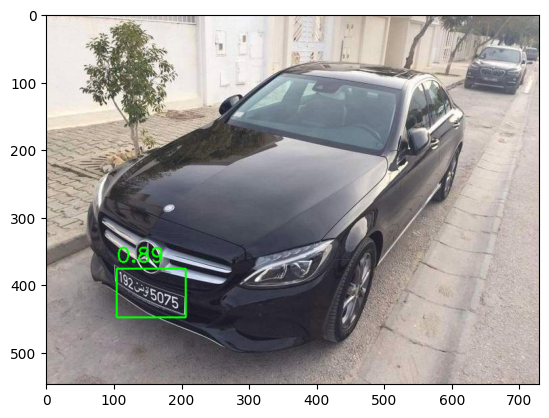

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt

# Load a test image
image = cv2.imread('/content/extracted_detection_images/license_plates_detection_train/130.jpg')


results = model(image)

# Check if results are returned as a list and access the first image's results
if isinstance(results, list):
    results = results[0]  # Get the first result from the list (in case of multiple images)

# The 'results' object should now have attributes like 'xyxy', 'confidence', etc.
# To print detection results (e.g., bounding boxes and confidence scores)
print("Detected boxes and confidence scores:")
for box in results.boxes:
    # Get bounding box coordinates (x1, y1, x2, y2)
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    conf = box.conf[0].item()  # Confidence score
    cls = box.cls[0].item()  # Class ID (e.g., 'license_plate' ID)

    print(f"License plate detected at coordinates: ({x1}, {y1}), ({x2}, {y2}) with confidence: {conf:.2f} and class ID: {cls}")

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(image, f"{conf:.2f}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Show the image with bounding boxes
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
model.save('best.pt')

In [ ]:
from ultralytics import YOLO

# Path to the trained model weights
model_path = '/content/best (1).pt'

# Load the trained model
model = YOLO(model_path)


In [ ]:
!pip install pytesseract

In [ ]:
import cv2
import pandas as pd
from pathlib import Path
import easyocr
from ultralytics import YOLO  # Use the ultralytics YOLO model

# Initialize EasyOCR Reader (English language)
reader = easyocr.Reader(['en'])

# Path to the trained model weights
model_path = '/content/best (1).pt'

# Load the trained model
model = YOLO(model_path)  # Load the custom YOLOv5 model

# Function to extract text using EasyOCR
def extract_text_from_plate(cropped_img):
    # Perform OCR using EasyOCR
    results = reader.readtext(cropped_img)
    extracted_text = ""

    # Collect text from the results (assuming the largest detected text block is the license plate)
    for result in results:
        extracted_text += result[1]  # Extract the text part

    return extracted_text.strip()

# Function to process and extract text from license plates
def process_license_plates(image_path):
    img = cv2.imread(image_path)
    results = model(image_path)  # Use YOLO to detect objects in the image

    # Iterate through the results (each is a detection)
    license_plates = []
    for result in results[0].boxes:  # Access the first item in the list (single image)
        # Each result contains bounding box coordinates, class, and confidence
        xmin, ymin, xmax, ymax = result.xyxy[0]  # Extract bounding box coordinates
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

        # Check if the detected object is a license plate (class 0 for license plates)
        if result.cls[0] == 0:  # Class 0 corresponds to license plates in your model
            cropped_img = img[ymin:ymax, xmin:xmax]  # Crop the detected license plate

            # Perform text extraction using EasyOCR
            plate_text = extract_text_from_plate(cropped_img)

            # Add extracted text to list
            license_plates.append(plate_text)

    return license_plates

# Set the path to your test images directory
test_images_path = Path("/content/extracted_detection_images/test/test")  # Replace with the correct directory path

# Prepare CSV data
csv_data = []

# Character-to-index mapping (assuming you already have this mapping)
char_to_idx = {str(i): i for i in range(10)}  # Example mapping (modify it based on your model)

# Iterate over all test images
for img_path in test_images_path.glob("*.jpg"):
    license_plates = process_license_plates(str(img_path))  # Extract license plate text
    for i, plate_text in enumerate(license_plates):
        # Ensure plate_text is no longer than 10 characters, truncate if necessary
        plate_text = plate_text[:10]  # Truncate to 10 characters if it's too long

        # Create a row with the image id and the characters in the license plate
        row = [f"{img_path.stem}_{i+1}"] + [char_to_idx.get(c, 0) for c in plate_text]

        # Make sure the row has a length of 11 (1 for id + 10 for characters)
        row.extend([0] * (11 - len(row)))  # Ensure exactly 10 characters per row

        # Add the row to csv data
        csv_data.append(row)

# Save the results to a CSV
df = pd.DataFrame(csv_data, columns=["id"] + [str(i) for i in range(10)])
df.to_csv("license_plate_predictions2.csv", index=False)

print("CSV file with license plate predictions has been saved successfully.")



image 1/1 /content/extracted_detection_images/test/test/1060.jpg: 640x416 1 license_plate, 168.7ms
Speed: 3.4ms preprocess, 168.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /content/extracted_detection_images/test/test/953.jpg: 480x640 1 license_plate, 170.3ms
Speed: 3.0ms preprocess, 170.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/extracted_detection_images/test/test/1084.jpg: 480x640 1 license_plate, 176.7ms
Speed: 4.5ms preprocess, 176.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/extracted_detection_images/test/test/911.jpg: 640x480 2 license_plates, 165.1ms
Speed: 3.3ms preprocess, 165.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/extracted_detection_images/test/test/932.jpg: 640x480 1 license_plate, 158.4ms
Speed: 3.2ms preprocess, 158.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /